#                 PROJECT: Customer churn prediction for the telecom operator Interconnect 

### Introduction. 
In this project, we will analyze data from the telecom operator Interconnect to predict customer churn. Our approach begins with preprocessing four datasets, preparing them for exploratory data analysis (EDA). Through feature engineering, we will define both the features and target variables for a supervised binary classification task.

To build the churn prediction model, we will train and evaluate several classification algorithms:

1. Logistic Regression
2. Random Forest Classifier
3. LightGBM Classifier
4. XGBoost
5. CatBoost

The performance of these models will be assessed using key metrics: accuracy, ROC-AUC, and F1 score. By fine-tuning hyperparameters, we will focus on achieving a ROC-AUC score greater than 0.75. Based on model performance, we will identify the best classifier to reliably forecast customer churn for Interconnect.


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier 


In [4]:
# downloading datasets
contract = pd.read_csv('contract.csv')
internet = pd.read_csv('internet.csv')
personal = pd.read_csv('personal.csv')
phone = pd.read_csv('phone.csv')


In [5]:
# Here we consider 'contract' dataframe

contract.info()
contract.duplicated().sum()
#No missing values, no duplicates 
# here, we rename the columns' names:
contract.rename(columns={'customerID': 'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 'Type':'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'}, inplace=True) 
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
# 'monthly_charges' column values are 'float' datatype, while 'total_carges' column values are 'object'. We convert the latter into float datatype: 

# We find out that 'total_charges' column has 11 ' ' values.  
empty_values = (contract['total_charges'] == '').sum() + (contract['total_charges'].str.isspace().sum()) 
print(f'empty_values: {empty_values}')

# The 'empty_values' correspond to the customers who just made first month (2020-02-01) payment. 
empty_space_rows = contract[contract['total_charges'].str.isspace()]
print(f'\n {empty_space_rows}')

'''Because these customers made the first (current) month payment, their total payment is equal to their first month payment. 
Thus, we fill ' ' values of the 'total_charges' with the corresponding values of the 'monthly_charges':'''

contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges']

# Now, we convert 'total_charges' values into float datatype:
contract['total_charges']= contract['total_charges'].astype(float)

contract.info()  # 'both monthly_charges' and 'total_charges' columns are now have float datatype


empty_values: 11

      customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mai

### Below we create target column called 'churn_col'

In [8]:
''' Here, according to the project instructions, using the 'end_date' column we create a new target column called 'churn_col' with 'no_churn' 
values corresponding to 'No' values,  and 'churn' corresponding to all other values of the original 'end_date' column, respectively.'''

contract['churn_col'] = contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   churn_col          7043 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 495.3+ KB


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn_col
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [9]:
# here we convert 'begin_date' and 'end_date' columns from 'object' datatype to datetime datatype

contract['begin_date'] = pd.to_datetime(contract['begin_date'])

# for 'end_date' convertion, we use errors = 'coerce' in order to keep 'No' values as a 'NaT' values of the column
contract['end_date'] = pd.to_datetime(contract['end_date'], errors = 'coerce')

print(contract.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn_col          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB
None


/var/folders/p7/krbf_vbj2lqf31fmqjz_j8xm0000gn/T/ipykernel_5356/4058758758.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['end_date'] = pd.to_datetime(contract['end_date'], errors = 'coerce')


In [10]:
# 'internet' dataset:

internet.info()
print(internet.isna().sum())
internet.duplicated().sum()
#No missing values, no duplicates
# Here, we rename columns' names:
internet.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service', 'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support', 'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'}, inplace=True)
internet.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
print(personal.info())
print(personal.isna().sum())
print(personal.duplicated().sum())
# No missing values, no duplicates

# Here, we rename the columns' name:
personal.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen', 'Partner':'partner', 'Dependents': 'dependents'}, inplace=True)

print(personal.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
0
     customer_id  gender  senior_citizen partner dependents
614   7138-GIRSH    Male               0      No         No
3561  5998-VVEJY    Male               0      No         No
6672  2346-CZYIL    Male               0      No         No
4763  4001-TSBTV  Female               0     Yes        Yes
1304  8519-IMDHU    Male               1     Yes         No


In [12]:
# 'phone' dataset

print(phone.info())
print(phone.isna().sum())
print(phone.duplicated().sum())
#No missing values, no duplicates
#Here, we rename the columns' name:
phone.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'}, inplace=True)
print(phone.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
customerID       0
MultipleLines    0
dtype: int64
0
  customer_id multiple_lines
0  5575-GNVDE             No
1  3668-QPYBK             No
2  9237-HQITU             No
3  9305-CDSKC            Yes
4  1452-KIOVK            Yes


## Merging datasets

In [14]:
# both 'contract' and 'personal' datasets have same number of rows, so we can make full joining using 'how=outer': 
merged_df = contract.merge(personal, on='customer_id', how='left')
# no missing values appear for this merging
merged_df.isna().sum()

merged_df = merged_df.merge(internet, on='customer_id', how='left')
merged_df.isna().sum()

merged_df = merged_df.merge(phone, on='customer_id', how='left')
merged_df.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
churn_col               0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [15]:
# Here, we fill all missing values, appeared due to merging the datasets, with 'unknown' 

merged_df[['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']] = merged_df[['internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']].fillna('unknown')  
merged_df.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn_col          7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

### EDA of merged data

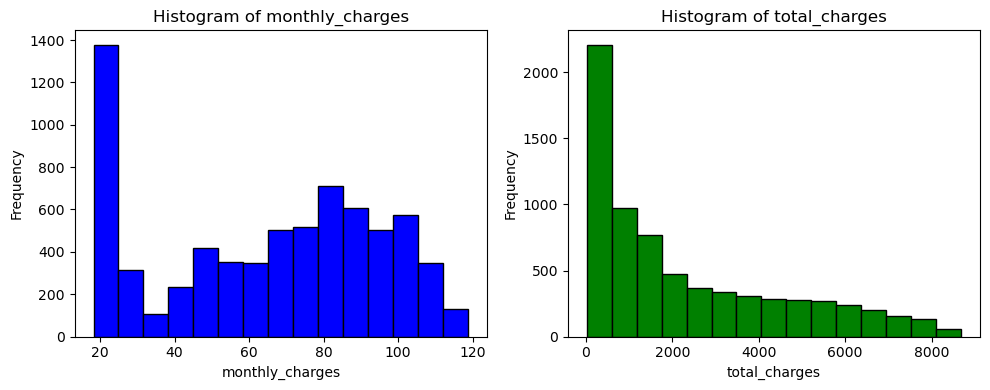

In [17]:
 
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Histogram for column A
axs[0].hist(merged_df['monthly_charges'], bins=15, color='blue', edgecolor='black')
axs[0].set_title('Histogram of monthly_charges')
axs[0].set_xlabel('monthly_charges')
axs[0].set_ylabel('Frequency')

# Histogram for column B
axs[1].hist(merged_df['total_charges'], bins=15, color='green', edgecolor = 'black')
axs[1].set_title('Histogram of total_charges')
axs[1].set_xlabel('total_charges')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Above shown histograms demonstrate that the value range (about 20 - 120) of 'monthly_charges' column is significantly differ from that 
#### of 'total_charges'. Later, we will consider standartization of these columns. 

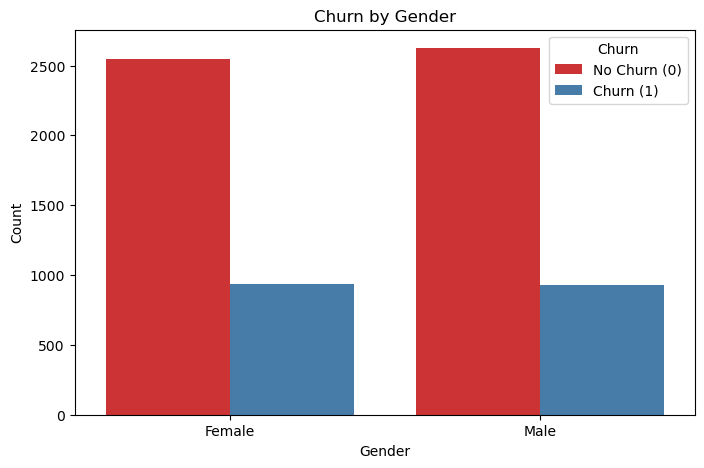

In [19]:
# Here, we check the realtion between 'gender' and 'churn_col' columns.

import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot
plt.figure(figsize=(8, 5))
sns.countplot(data=merged_df, x='gender', hue='churn_col', palette='Set1')

# Adding titles and labels
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right', labels=['No Churn (0)', 'Churn (1)'])

plt.show()

In [20]:
# above shown plot demonstrate that 'churn_col' behaves as independendt from 'male' and 'female' values.
#Therefore we remove 'gender' column from the dataset.

# Also, now we can remove 'end_date' column, too. Its values has been already used to create 'churn_col' column. 

# Also, we drop 'paperless_billing' and 'payment_method' columns, beacause we assume that they do not affect the churn analysis.
merged_df.head()
#df_cleaned = merged_df.drop(columns={'end_date', 'paperless_billing', 'payment_method', 'gender'})
df_cleaned = merged_df.drop(columns={'end_date', 'paperless_billing', 'payment_method', 'gender'})

df_cleaned.info() 

print(df_cleaned.head(5))
print(df_cleaned.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   monthly_charges    7043 non-null   float64       
 4   total_charges      7043 non-null   float64       
 5   churn_col          7043 non-null   int64         
 6   senior_citizen     7043 non-null   int64         
 7   partner            7043 non-null   object        
 8   dependents         7043 non-null   object        
 9   internet_service   7043 non-null   object        
 10  online_security    7043 non-null   object        
 11  online_backup      7043 non-null   object        
 12  device_protection  7043 non-null   object        
 13  tech_support       7043 non-null   object        
 14  streamin

In [21]:
# He we check columns' imbalances:

print(df_cleaned['type'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are 56:44. No strongly imbalanced. 

print(df_cleaned['churn_col'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: 0: 5174 (73.6%), 1: 1869 (26.4%). Strongly imbalanced. We work on balancing it.  

print(df_cleaned['senior_citizen'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: 0: 5901 (83.6%), 1: 1142 (16.4%). Strongly imbalanced. We work on balancing it.  

print(df_cleaned['partner'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 3641 (51.7%), Yes: 3402 (48.3%). No strongly imbalanced. 

print(df_cleaned['dependents'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 4933 (70.0%), Yes: 2110 (30.0%). Imbalanced. 

print(df_cleaned['internet_service'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: Fiber optic: 3096 (43.4%), DSL: 2421 (34.3%), 0: 1526 (22.3%). No strongly imbalanced. 

print(df_cleaned['online_security'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 3498 (49.4%), Yes: 2019 (27.9%), 0: 1526 (22.7%). No strongly imbalanced. 

print(df_cleaned['online_backup'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 3088 (43.5%), Yes: 2429 (34.5%), 0: 1526 (22.0%). No strongly imbalanced.

print(df_cleaned['device_protection'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 3095 (43.5%), Yes: 2422 (34.5%), 0: 1526 (22.0%). No strongly imbalanced. 

print(df_cleaned['tech_support'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 3473 (49.5%), Yes: 2044 (28.6%), 0: 1526 (21.9%). No strongly imbalanced. 

print(df_cleaned['streaming_tv'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 2810 (39.7%), Yes: 2707 (39.1%), 0: 1526 (21.2%). No strongly imbalanced. 

print(df_cleaned['streaming_movies'].value_counts(dropna=False))
# it has two unique values, ratio of the unique values are: No: 2785 (39.1%), Yes: 2732 (38.9%), 0: 1526 (22.0%). No trongly imbalanced.

print(df_cleaned['multiple_lines'].value_counts(dropna=False))
#it has two unique values, ratio of the unique values are: No: 3390 (54.5%), Yes: 2971 (45.5%), 0: 682 (0.0%). No strongly imbalanced.

# Strongly Imbalanced Columns are: 'churn_col', 'senior_citizen' and 'dependents'. 


type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
churn_col
0    5174
1    1869
Name: count, dtype: int64
senior_citizen
0    5901
1    1142
Name: count, dtype: int64
partner
No     3641
Yes    3402
Name: count, dtype: int64
dependents
No     4933
Yes    2110
Name: count, dtype: int64
internet_service
Fiber optic    3096
DSL            2421
unknown        1526
Name: count, dtype: int64
online_security
No         3498
Yes        2019
unknown    1526
Name: count, dtype: int64
online_backup
No         3088
Yes        2429
unknown    1526
Name: count, dtype: int64
device_protection
No         3095
Yes        2422
unknown    1526
Name: count, dtype: int64
tech_support
No         3473
Yes        2044
unknown    1526
Name: count, dtype: int64
streaming_tv
No         2810
Yes        2707
unknown    1526
Name: count, dtype: int64
streaming_movies
No         2785
Yes        2732
unknown    1526
Name: count, dtype: int64
multiple_lines
No         

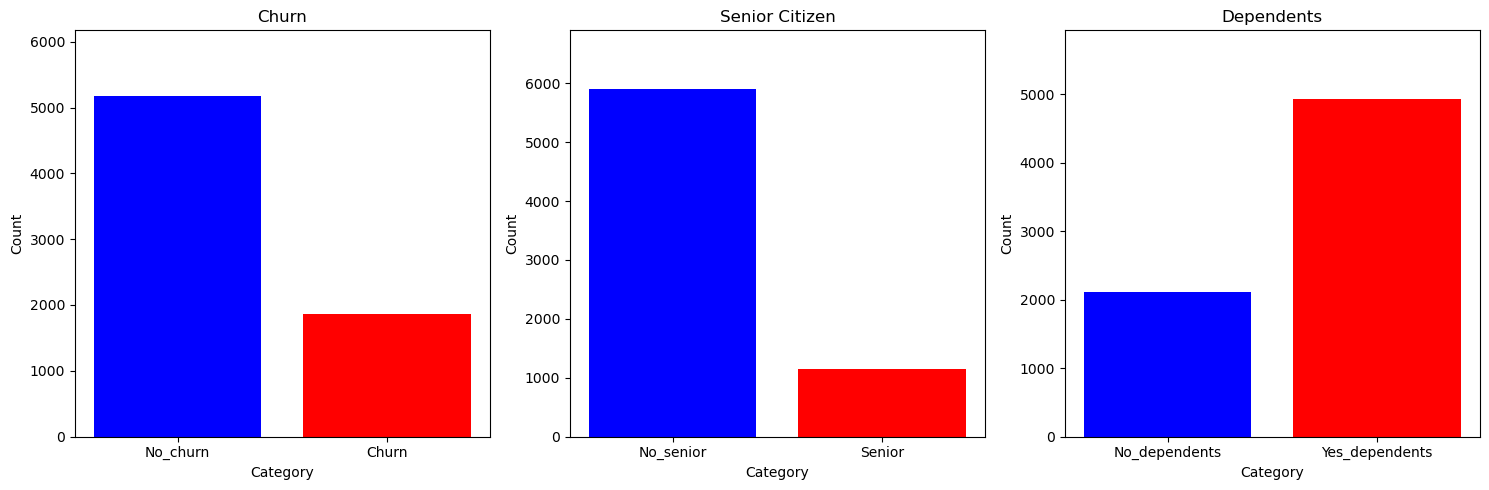

In [22]:
# Bar view of the strongly imbalanced columns 'churn_col', 'senior_citizen' and 'dependents'.

data = {'Churn': [5174, 1869], 'Senior Citizen': [5901, 1142], 'Dependents': [2110, 4933]}

# Labels for each category
labels = {'Churn': ['No_churn', 'Churn'], 'Senior Citizen': ['No_senior', 'Senior'], 'Dependents': ['No_dependents', 'Yes_dependents']}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms
for ax, (key, values) in zip(axs, data.items()):
    ax.bar(labels[key], values, color=['blue', 'red'])
    ax.set_title(key)
    ax.set_ylabel('Count')
    ax.set_xlabel('Category')
    ax.set_ylim(0, max(values) + 1000)  # Adjust y-axis limit for better visibility

# Adjust layout
plt.tight_layout()
plt.show()


#### Above shown histograms clealry demonstrate the class imbalances of the given columns. We will take into account these imbalances in model training. 

# Model training

In [25]:
# Splitting data into train, validation and test datasets

features = df_cleaned.drop('churn_col', axis=1)
target = df_cleaned['churn_col']

#split into temporary and test datasets
features_temp, features_test, target_temp, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

#split into train and validation datasets
features_train, features_valid, target_train, target_valid = train_test_split(features_temp, target_temp, test_size=0.25, random_state=12345)


In [26]:
# Here we apply OHE to encode the categorical features and StandardScaler to standardize the numeric features:

categorical_features = ['type', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
numerical_features = ['senior_citizen', 'monthly_charges', 'total_charges']

# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()
passthrough_transformer = FunctionTransformer(lambda x: x)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features),
        ('passtrough', passthrough_transformer, ['senior_citizen'])   # Here, this code is added in order 'senior_citizen' feature not affected by StandardScaler
    ])


### Below, we create train_and_evaluate function

In [28]:
def train_and_evaluate_model(pipeline, param_grid, X_train, y_train, X_val, y_val):
    """
    Fits the model using GridSearchCV, makes predictions, and evaluates metrics.
    
    Parameters:
    - pipeline: The model pipeline to train and evaluate.
    - param_grid: The parameter grid for hyperparameter tuning.
    - X_train: Training features.
    - y_train: Training target.
    - X_val: Validation features.
    - y_val: Validation target.
    
    Returns:
    - A dictionary containing best parameters, accuracy, F1 score, and ROC AUC score.
    """
    
    # Grid search
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid,
                               scoring=['roc_auc', 'accuracy', 'f1'],
                               refit='roc_auc',
                               cv=5,
                               return_train_score=True)
    
    # Fitting the model
    grid_search.fit(X_train, y_train)
    
    # Getting the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Makeing predictions on the validation set
    y_val_pred = best_model.predict(X_val)
    y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Calculating the metrics
    accuracy = accuracy_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    f1 = f1_score(y_val, y_val_pred)
    
    # Printing the results
    print(f'Best Params: {best_params}')
    print(f'Validation Accuracy: {accuracy:.4f}')
    print(f'Validation ROC AUC: {roc_auc:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'f1_score': f1,
    }

### LogisticRegression

In [30]:
# Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', random_state=12345))
])

param_grid_logreg = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__max_iter': [100, 200, 300],
}

results_lr = train_and_evaluate_model(pipeline_lr, param_grid_logreg, features_train, target_train, features_valid, target_valid)


Best Params: {'model__C': 0.1, 'model__max_iter': 100, 'model__solver': 'liblinear'}
Validation Accuracy: 0.7346
Validation ROC AUC: 0.8188
Validation F1 Score: 0.5952


#### Results of LogisticRegrression model with validation dataset

1. Best Params: {'model__C': 0.1, 'model__max_iter': 100, 'model__solver': 'liblinear'}
2. Validation Accuracy: 0.7346
3. Validation ROC AUC: 0.8188
4. Validation F1 Score: 0.5952


### RandomForestClassifier model

In [ ]:
# Random Forest

# Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state = 12345))
])

param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
}

results_rf = train_and_evaluate_model(pipeline_rf, param_grid_rf, features_train, target_train, features_valid, target_valid)


#### RandomFOrestClassifier results with validation dataset:
1. Best Params: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}
2. Validation Accuracy: 0.7516
3. Validation ROC AUC: 0.8186
4. Validation F1 Score: 0.5930


### LightGBMClassifier model



In [ ]:
# LightGBM
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(class_weight='balanced', verbose=-1))
])

param_grid_lgbm = {
    'model__n_estimators': [20, 50],
    'model__max_depth': [5, 10],
    'model__learning_rate': [0.1, 0.2],
    'model__num_leaves': [15, 31],
}

results_lgbm = train_and_evaluate_model(pipeline_lgbm, param_grid_lgbm, features_train, target_train, features_valid, target_valid)


### Results of the LightGBM model
1. Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__num_leaves': 15}
2. Validation Accuracy: 0.7466
3. Validation ROC AUC: 0.8314
4. Validation F1 Score: 0.5993


### XGBoost model

In [ ]:
# XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', verbosity=0))
])

param_grid_xgb = {
    'model__n_estimators': [20, 50],
    'model__max_depth': [3, 5, 10],
    'model__learning_rate': [0.1, 0.02],
    'model__subsample': [0.5, 0.8],
    'model__colsample_bytree': [0.5, 0.8],
}

results_xgb = train_and_evaluate_model(pipeline_xgb, param_grid_xgb, features_train, target_train, features_valid, target_valid)


### XGBoost model results: 
1. Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
2. Validation Accuracy: 0.8062
3. Validation ROC AUC: 0.8355
4. Validation F1 Score: 0.5646


### CatBoost model

In [ ]:
# CatBoostClassifier: because this model handle the encoding of categorical features inherently we provided data directly without preprocessor.
X = df_cleaned.drop(columns=['churn_col', 'customer_id', 'begin_date']) 
y = df_cleaned['churn_col']

# Splitting the data into training and test sets
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42)

# categorical features
categor_features = [
    'type', 'partner', 'dependents', 'internet_service', 
    'online_security', 'online_backup', 'device_protection', 
    'tech_support', 'streaming_tv', 'streaming_movies', 
    'multiple_lines'
]

catboost_model = CatBoostClassifier(cat_features=categor_features, verbose=0)

param_grid_catboost = {
    'iterations': [20, 60, 70],
    'learning_rate': [0.1, 0.2],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [0.5, 1, 3],
}

results_catboost = train_and_evaluate_model(catboost_model, param_grid_catboost, X_train, y_train, X_val, y_val)


## CatBoost results

1. Best Params: {'depth': 3, 'iterations': 70, 'l2_leaf_reg': 0.5, 'learning_rate': 0.2}
2. Validation Accuracy: 0.7933
3. Validation ROC AUC: 0.8428
4. Validation F1 Score: 0.5612


###  Among the above trained and tested models, CatBoost outputs highest ROC-AUC value. Below we use this model with 'test' dataset to make predictions.

In [ ]:
# 'test' dataset with the best model:

# Extracting the best model from results
best_catboost_model = results_catboost['best_model']

# Making predictions on the test set
y_test_pred = best_catboost_model.predict(X_test)
y_test_pred_proba = best_catboost_model.predict_proba(X_test)[:, 1]

# Calculating metrics for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# Printing the test metrics
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


### Conclusion. 
In this project, we analyzed data from the telecom operator Interconnect to predict customer churn. The data was preprocessed, relevant features were engineered, and exploratory data analysis (EDA) was conducted to prepare for a supervised binary classification task.

To address class imbalances, one-hot encoding (OHE) was applied, and numerical features were standardized. The following classification models were trained and evaluated:

1. Logistic Regression
2. Random Forest Classifier
3. LightGBM Classifier
4. XGBoost
5. CatBoost

Model performance was assessed using the accuracy, ROC-AUC, and F1 score metrics. The results are summarized in the table below:

|          Models         |  Dataset     |  Accuracy    |  F1_score    |  ROC-AUC      |
|-------------------------|--------------|--------------|--------------|---------------|
| LogisticRegresssion     | validation   |  0.735       |  0.595       |   0.819       |
| RandomForestClassifier  | validation   |  0.752       |  0.593       |   0.819       |
| LightGBM                | validation   |  0.747       |  0.599       |   0.831       |
| XGBoost                 | validation   |  0.806       |  0.565       |   0.836       |
| Catboost                | validation   |  0.793       |  0.561       |   0.842       |
| Catboost                | test         |  0.801       |  0.573       |   0.861       |


After fine-tuning the models' hyperparameters and evaluating them on the test dataset, CatBoost emerged as the best model, achieving a ROC-AUC of 0.8634.

Based on these results, we recommend using the CatBoost model with the tuned hyperparameters to predict customer churn for the company.